### Description - Modified XGBoost model by @titericz

XGBoost model created using @titericz model as reference. Instead of forecasting the monthly variation of "microbusiness_density" directly, we will forecast the monthly variation of "active" feature. This is because the population in each year is constante and when the year change, the population is atualized and the "microbusiness_density" change as well.

### Libraries

In [1]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [2]:
%reload_ext watermark
%watermark -a "Ulisses Morais" --iversions

Author: Ulisses Morais

matplotlib: 3.5.1
pandas    : 1.5.3
xgboost   : 1.7.2
numpy     : 1.22.4



In [3]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure",
       autolayout=True,
       figsize=(8, 4),
       titlesize=18,
       titleweight='bold',
      )
plt.rc("axes",
       labelweight="bold",
       labelsize="large",
       titleweight="bold",
       titlesize=16,
       titlepad=10,
      )
plot_params = dict(color="0.75",
                   style=".-",
                   markeredgecolor="0.25",
                   markerfacecolor="0.25",
                  )
%config InlineBackend.figure_format = 'retina'


In [4]:
def smape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * np.mean(smap)

def vsmape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * smap

### 1. Basic Processing

In [5]:
train = pd.read_csv('./files/train.csv')
test = pd.read_csv('./files/test.csv')
rev_test = pd.read_csv('./files/revealed_test.csv')
sub = pd.read_csv('./files/sample_submission.csv')
print(train.shape, test.shape, sub.shape, rev_test.shape)  # (122265, 7) (25080, 3) (25080, 2)

train['istest'] = 0
rev_test['istest'] = 0
test['istest'] = 1

test = test.loc[~test.first_day_of_month.isin(['2022-11-01','2022-12-01'])]

raw = (pd.concat((train, test, rev_test))          # concat train and test data, and sort by cfips first, and then sort by row_id for each cfips
       .sort_values(['cfips','row_id'])  # since row_id has a format 'cfips-first day of month', basically we sort by time
       .reset_index(drop=True)           # because we have both train and test, the index is confounded. so we drop the index first and then give the joined table a new index from 0
      )


# set datetime format
raw['first_day_of_month'] = pd.to_datetime(raw["first_day_of_month"])

# complete the county for the test set data thas was concatenated
raw['county'] = (raw
                 .groupby('cfips')['county']
                 .ffill()
                )

# complete the state for the test set data thas was concatenated
raw['state'] = (raw
                .groupby('cfips')['state']
                .ffill()
               )

# set year and month to dataframe
raw["year"] = raw["first_day_of_month"].dt.year
raw["month"] = raw["first_day_of_month"].dt.month
raw['first_day_of_month'] = raw['first_day_of_month'].astype(str)

# set a value to each month
raw["dcount"] = (raw
                 .groupby(['cfips'])['row_id']
                 .cumcount()
                )

# attach a specific value to conty ans state
raw['county_i'] = (raw['county'] + raw['state']).factorize()[0]
raw['state_i'] = raw['state'].factorize()[0]

(122265, 7) (25080, 3) (25080, 2) (6270, 7)


In [6]:
raw.head(50)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_i,state_i
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,0,2019,8,0,0,0
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,2019,9,1,0,0
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,2019,10,2,0,0
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243.0,0,2019,11,3,0,0
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243.0,0,2019,12,4,0,0
5,1001_2020-01-01,1001,Autauga County,Alabama,2020-01-01,2.969090,1242.0,0,2020,1,5,0,0
6,1001_2020-02-01,1001,Autauga County,Alabama,2020-02-01,2.909326,1217.0,0,2020,2,6,0,0
7,1001_2020-03-01,1001,Autauga County,Alabama,2020-03-01,2.933231,1227.0,0,2020,3,7,0,0
8,1001_2020-04-01,1001,Autauga County,Alabama,2020-04-01,3.000167,1255.0,0,2020,4,8,0,0
9,1001_2020-05-01,1001,Autauga County,Alabama,2020-05-01,3.004948,1257.0,0,2020,5,9,0,0


#### 1.1 Economic rates (CPI and Treasury 10Y)

In [7]:
# load economic rates
econ_rates = pd.read_csv('./files/economic_rates.csv',
                         parse_dates=['first_day_of_month'],
                         index_col='first_day_of_month',
                        )

# map economic rates (cpi and treasury 10Y) into raw dataframe
raw = (raw
       .assign(cpi_monthly = raw['first_day_of_month'].map(econ_rates['cpi_monthly']),
               treasury10y = raw['first_day_of_month'].map(econ_rates['treasury10y']),
              )
      )

econ_rates.head(3)

,cpi_monthly,treasury10y
first_day_of_month,,
2019-08-01,0.1,2.007
2019-09-01,0.2,1.499
2019-10-01,0.3,1.668


In [8]:
raw.head(3)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_i,state_i,cpi_monthly,treasury10y
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,0,2019,8,0,0,0,0.1,2.007
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,2019,9,1,0,0,0.2,1.499
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,2019,10,2,0,0,0.3,1.668


#### 1.2 Unemployment rate

In [9]:
unmp_rate = pd.read_csv('./files/state_unemployment.csv')

unmp_rate['id_map'] = (unmp_rate['first_day_of_month'] +'_' + unmp_rate['state'])
unmp_rate = unmp_rate.set_index('id_map')
unmp_rate.head(3)

,first_day_of_month,unemployment_rate,state
id_map,,,
2019-01-01_Alabama,2019-01-01,3.7,Alabama
2019-02-01_Alabama,2019-02-01,3.6,Alabama
2019-03-01_Alabama,2019-03-01,3.4,Alabama


In [10]:
# map the unemployment rate in each state
raw['pct_unemployment'] = (raw['first_day_of_month'] +'_' + raw['state']).map(unmp_rate['unemployment_rate'])
raw.head(3)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_i,state_i,cpi_monthly,treasury10y,pct_unemployment
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,0,2019,8,0,0,0,0.1,2.007,2.9
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,2019,9,1,0,0,0.2,1.499,2.9
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,2019,10,2,0,0,0.3,1.668,3.0


#### 1.3 Population

In [11]:
def clean_popdf(df):
    # Change columns name
    df.columns = ['cfips', 'county', 'population2021']
    df['population2021'] = df['population2021'].astype(np.int64)
    df['cfips'] = df['cfips'].str.split('S', expand=True)[1]
    df['cfips'] = df['cfips'].astype(np.int64)
    df = df.set_index('cfips')
    
    return df

In [12]:
def map_pop(raw, pop_2021):
    
    raw['population'] = round(100 * raw['active'] / raw['microbusiness_density'], 0)
    raw['population'] = raw['population'].fillna(method="ffill").astype(np.int64)
    
    df = raw.loc[raw.dcount.isin([41,42,43,44,45,46])].copy()
    df['population'] = df['cfips'].map(pop_2021.to_dict()['population2021'])
    raw.loc[(raw.istest == 1) & (raw.year == 2023), 'population'] = df.loc[:, 'population']

    return raw

In [13]:
# load 2021 population data
pop_2021 = pd.read_csv('./files/ACSDP5Y2021.DP05-Data.csv',
                       usecols=['GEO_ID', 'NAME', 'DP05_0021E'],
                      ).drop(0, axis=0)


pop_2021 = clean_popdf(pop_2021)

raw = map_pop(raw, pop_2021)
raw.head(3)

C:\Users\DELL\AppData\Local\Temp\ipykernel_6048\3555398683.py:2: DtypeWarning: Columns (82) have mixed types. Specify dtype option on import or set low_memory=False.
  pop_2021 = pd.read_csv('./files/ACSDP5Y2021.DP05-Data.csv',


,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_i,state_i,cpi_monthly,treasury10y,pct_unemployment,population
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,0,2019,8,0,0,0,0.1,2.007,2.9,41527
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,2019,9,1,0,0,0.2,1.499,2.9,41527
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,2019,10,2,0,0,0.3,1.668,3.0,41527


In [14]:
raw.head(50)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_i,state_i,cpi_monthly,treasury10y,pct_unemployment,population
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,0,2019,8,0,0,0,0.1,2.007,2.9,41527
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,2019,9,1,0,0,0.2,1.499,2.9,41527
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,2019,10,2,0,0,0.3,1.668,3.0,41527
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243.0,0,2019,11,3,0,0,0.2,1.688,3.1,41527
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243.0,0,2019,12,4,0,0,0.2,1.774,3.2,41527
5,1001_2020-01-01,1001,Autauga County,Alabama,2020-01-01,2.969090,1242.0,0,2020,1,5,0,0,0.2,1.919,3.3,41831
6,1001_2020-02-01,1001,Autauga County,Alabama,2020-02-01,2.909326,1217.0,0,2020,2,6,0,0,0.1,1.505,3.4,41831
7,1001_2020-03-01,1001,Autauga County,Alabama,2020-03-01,2.933231,1227.0,0,2020,3,7,0,0,-0.3,1.163,3.6,41831
8,1001_2020-04-01,1001,Autauga County,Alabama,2020-04-01,3.000167,1255.0,0,2020,4,8,0,0,-0.8,0.668,13.7,41831
9,1001_2020-05-01,1001,Autauga County,Alabama,2020-05-01,3.004948,1257.0,0,2020,5,9,0,0,-0.1,0.646,10.4,41831


### 2. Anomaly detection

In [15]:
lag = 1

# .shift(lag): for each cfips, shift its density column by lag=1, so the density in each first row will be NAN. -> you get a column with the length = len('density')
# .bfill(): fill NaN with the next valid density, so the density in each cfips' first row will be the original value, but note that
#           1001's density from 2022-12-01 to 2023-06-01 will be back filled by the first density of 1003 (the next cfips), in this new column 'mbd_lag_1'.
#           but, it turns out that doesn't really matter
# NOTE THAT, in the engineering, 'mbd_lag_1' is overwrite by new feature
# raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')['microbusiness_density'].shift(lag).bfill()

raw[f'act_lag_{lag}'] = (raw
                     .groupby('cfips')['active']
                     .shift(lag)
                     .bfill()
                    )

# basically, 'dif' means the 'percentage increment' of the density from the previous month to this month
# raw['dif'] = (raw['microbusiness_density'] / raw[f'mbd_lag_{lag}']).fillna(1).clip(0, None) - 1

raw['act_var'] = (raw['active'] / raw[f'act_lag_{lag}']).fillna(1).clip(0, None) - 1

# if there are zeros in density, then we need to deal with special cases:
#    density  mbd_lag_1  div  fillna  clip  diff
#       1         1       1                 -> 0   
#       2         1       2                 -> 1
#       0         2       0                 -> -1
#       0         0      inf                -> inf     special cases
#       4         0      inf                -> inf     special cases
#      Nan        4      Nan    -> 1        -> 0
#      Nan        Nan    Nan    -> 1        -> 0
#      Nan        Nan    Nan    -> 1        -> 0

# --------------------------------------------
raw.loc[(raw[f'act_lag_{lag}']==0), 'act_var'] = 0
#    density  mbd_lag_1  div  fillna   diff
#       1         1       1          -> 0   
#       2         1       2          -> 1
#       0         2       0          -> -1
#       0         0      inf         -> inf     special cases -> 0
#       4         0      inf         -> inf     special cases -> 0
#      Nan        4      Nan    -> 1 -> 0
#      Nan        Nan    Nan    -> 1 -> 0
#      Nan        Nan    Nan    -> 1 -> 0


raw.loc[(raw['active'] > 0) & (raw[f'act_lag_{lag}'] == 0), 'act_var'] = 1
# #    density  mbd_lag_1  div  fillna   diff
# #       1         1       1          -> 0   
# #       2         1       2          -> 1
# #       0         2       0          -> -1
# #       0         0      inf         -> inf     special cases -> 0
# #       4         0      inf         -> inf     special cases -> 0 -> 1   # is 1 a reasonable number?
# #      Nan        4      Nan    -> 1 -> 0
# #      Nan        Nan    Nan    -> 1 -> 0
# #      Nan        Nan    Nan    -> 1 -> 0

# # -------------------------

raw['act_var'] = raw['act_var'].abs()

In [16]:
raw.head(10)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_i,state_i,cpi_monthly,treasury10y,pct_unemployment,population,act_lag_1,act_var
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,0,2019,8,0,0,0,0.1,2.007,2.9,41527,1249.0,0.000000
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,2019,9,1,0,0,0.2,1.499,2.9,41527,1249.0,0.040833
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,2019,10,2,0,0,0.3,1.668,3.0,41527,1198.0,0.059265
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243.0,0,2019,11,3,0,0,0.2,1.688,3.1,41527,1269.0,0.020489
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243.0,0,2019,12,4,0,0,0.2,1.774,3.2,41527,1243.0,0.000000
5,1001_2020-01-01,1001,Autauga County,Alabama,2020-01-01,2.969090,1242.0,0,2020,1,5,0,0,0.2,1.919,3.3,41831,1243.0,0.000805
6,1001_2020-02-01,1001,Autauga County,Alabama,2020-02-01,2.909326,1217.0,0,2020,2,6,0,0,0.1,1.505,3.4,41831,1242.0,0.020129
7,1001_2020-03-01,1001,Autauga County,Alabama,2020-03-01,2.933231,1227.0,0,2020,3,7,0,0,-0.3,1.163,3.6,41831,1217.0,0.008217
8,1001_2020-04-01,1001,Autauga County,Alabama,2020-04-01,3.000167,1255.0,0,2020,4,8,0,0,-0.8,0.668,13.7,41831,1227.0,0.022820
9,1001_2020-05-01,1001,Autauga County,Alabama,2020-05-01,3.004948,1257.0,0,2020,5,9,0,0,-0.1,0.646,10.4,41831,1255.0,0.001594


#### Let's see which dcount (time point) has a SIGNIFICANT increase than the previous month!

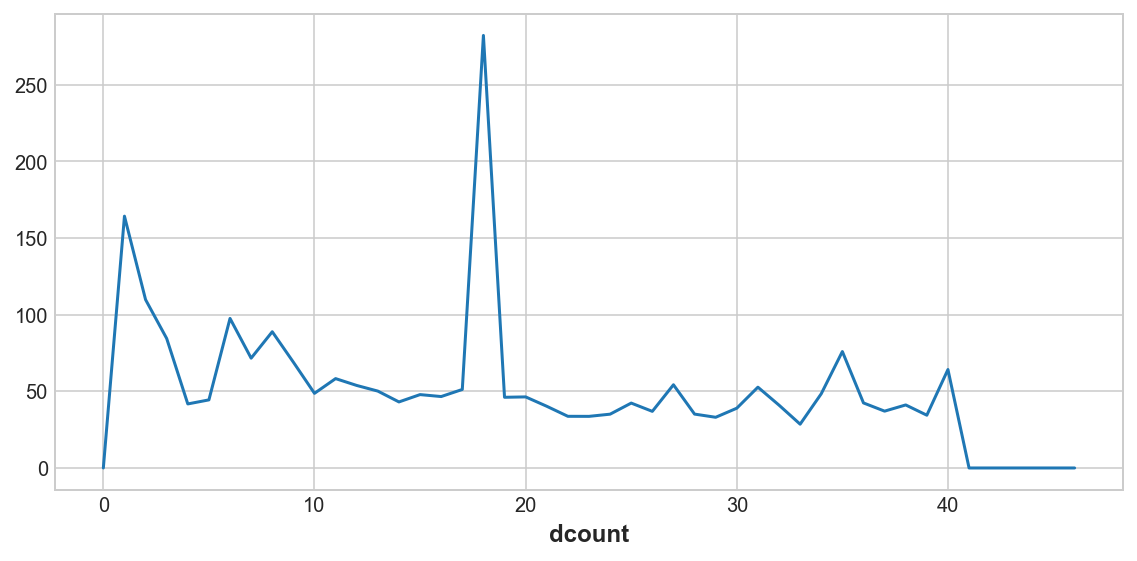

In [17]:
# raw.groupby('dcount')['dif'].sum().plot();
raw.groupby('dcount')['act_var'].sum().plot();

#### Smoothing & Outlier correction

In [18]:
outliers = []   # record which cfips has outliners
cnt = 0         # the tot num of outliners

for cfip in tqdm(raw.cfips.unique()):                      # each cfips
    
    indices = (raw['cfips'] == cfip)                       # get all the idx for that cfips
    tmp = raw.loc[indices].copy().reset_index(drop=True)   # get all the rows for the cfips, reset_index make each tmp index from zero
    var = tmp['active'].values.copy()                      # copy density data for the current cfips
    #vmax = np.max(var[:38]) - np.min(var[:38])

    for i in range(37, 2, -1):                # idx 37 ~ 3. Note: 0 ~ 38 is training data
                                              # why not consider 38? 2?  # i think you can even set it to 0
        thr = 0.20 * np.mean(var[:i])         # use 20% average of the points before current point i as the anomaly value TH
        difa = abs(var[i] - var[i-1])         # if the current point i's increase is bigger than thr, we consider it as a anomaly change, not natural trend
        
        if (difa >= thr):                     # so we 'lift' all the previous values to the same 'stage' of the current point
            
            var[:i] *= ( var[i] / var[i-1] )
            outliers.append(cfip)             # save which cfips has outliers
            cnt += 1                          # total count
    
    # why not set the above for loop as range(37,0,-1)? so we don't need the line below
    var[0] = var[1] * 0.99               # why do this hard code 0.99? make the first -> second unchanged almost? 
    
    raw.loc[indices, 'active'] = var  # the smoothed density
    
outliers = np.unique(outliers)
len(outliers), cnt

  0%|          | 0/3135 [00:00<?, ?it/s]

C:\Users\DELL\AppData\Local\Temp\ipykernel_6048\1162578263.py:18: RuntimeWarning: invalid value encountered in double_scalars
  var[:i] *= ( var[i] / var[i-1] )
C:\Users\DELL\AppData\Local\Temp\ipykernel_6048\1162578263.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  var[:i] *= ( var[i] / var[i-1] )
C:\Users\DELL\AppData\Local\Temp\ipykernel_6048\1162578263.py:18: RuntimeWarning: invalid value encountered in multiply
  var[:i] *= ( var[i] / var[i-1] )
C:\Users\DELL\AppData\Local\Temp\ipykernel_6048\1162578263.py:14: RuntimeWarning: invalid value encountered in double_scalars
  difa = abs(var[i] - var[i-1])         # if the current point i's increase is bigger than thr, we consider it as a anomaly change, not natural trend


(475, 716)

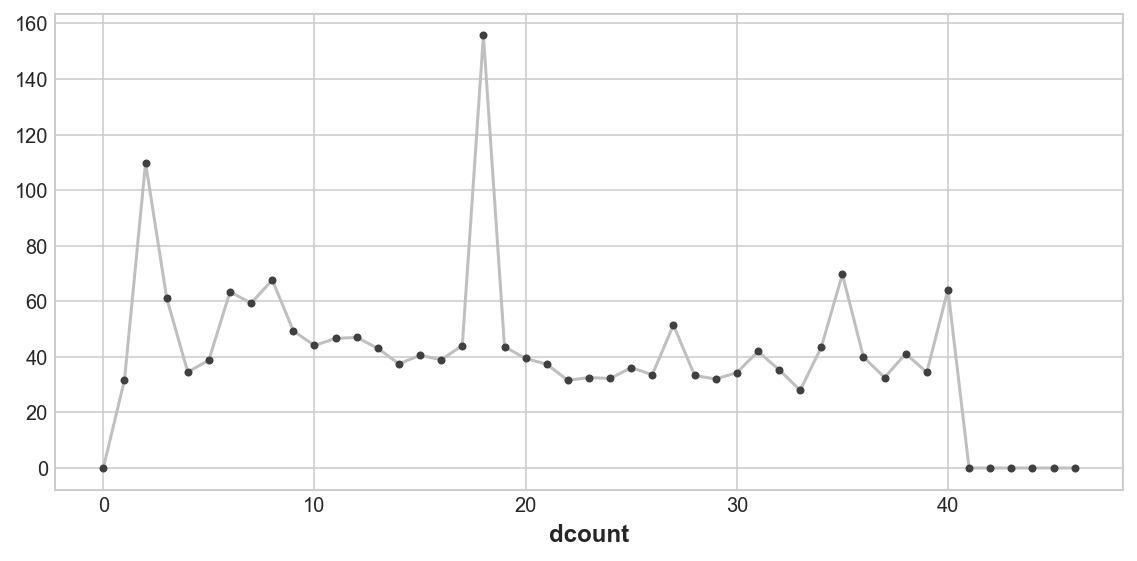

In [19]:
# Do the steps earlier again
lag = 1

raw[f'act_lag_{lag}'] = raw.groupby('cfips')['active'].shift(lag).bfill()
raw['act_var'] = (raw['active'] / raw[f'act_lag_{lag}']).fillna(1).clip(0, None) - 1
raw.loc[(raw[f'act_lag_{lag}'] == 0), 'act_var'] = 0
raw.loc[(raw[f'active'] > 0) & (raw[f'act_lag_{lag}'] == 0), 'act_var'] = 1
raw['act_var'] = raw['act_var'].abs()

# Plot
raw.groupby('dcount')['act_var'].sum().plot(**plot_params);

<AxesSubplot:xlabel='first_day_of_month'>

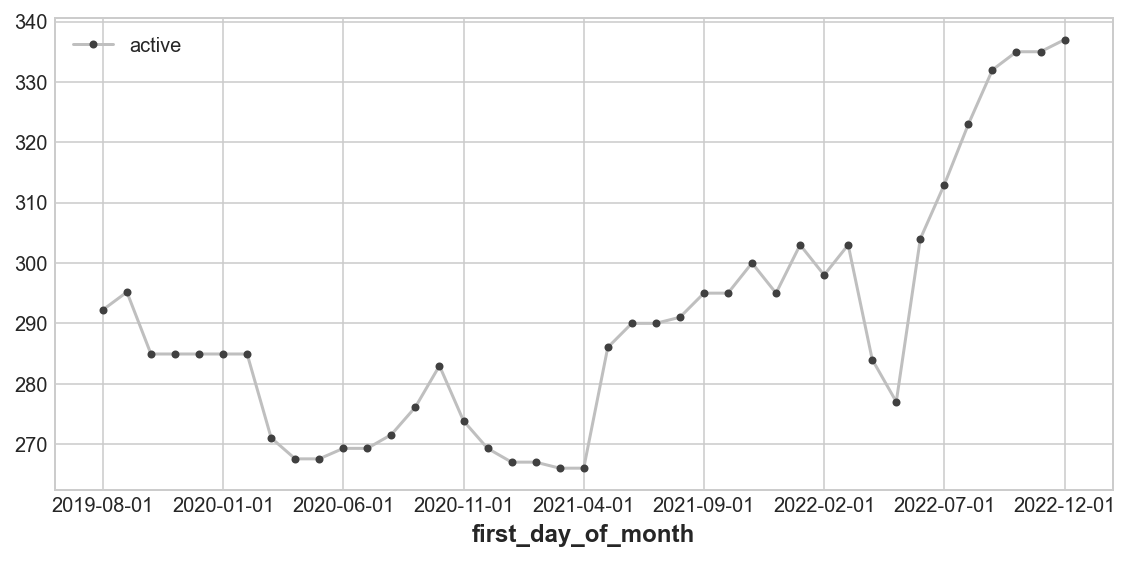

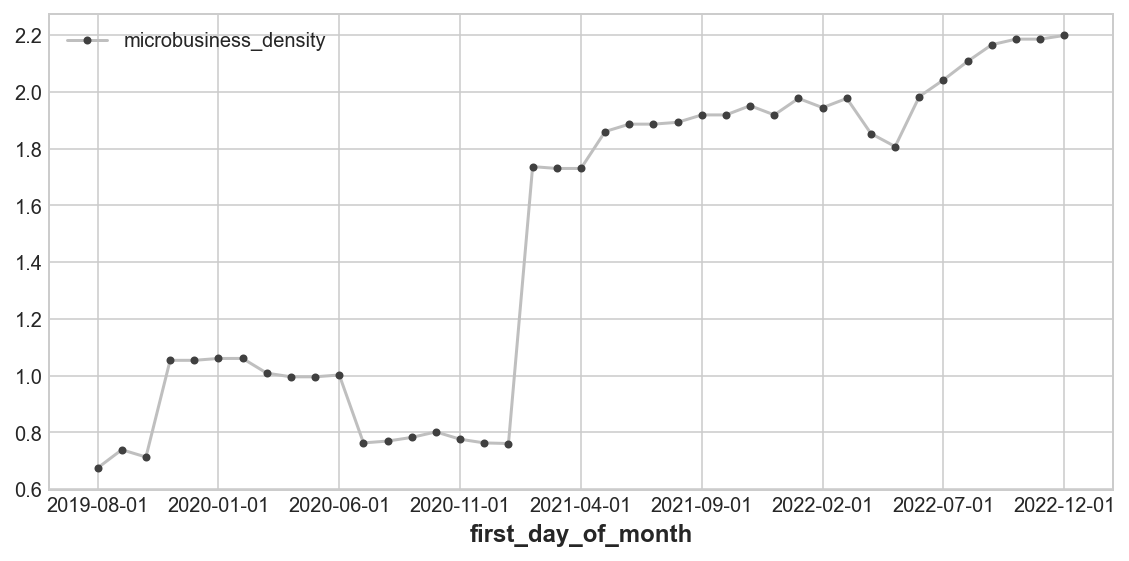

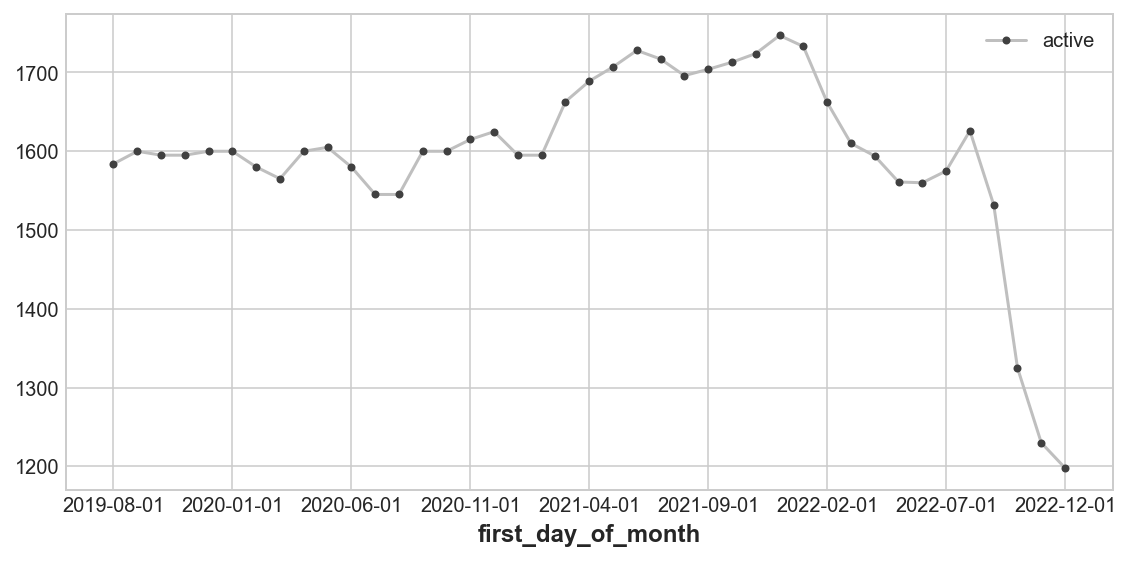

In [20]:
# plot two cfips density change over time
raw.loc[raw.cfips == 1013].plot(x='first_day_of_month', y='active', **plot_params)
raw.loc[raw.cfips == 1013].plot(x='first_day_of_month', y='microbusiness_density', **plot_params)
raw.loc[raw.cfips == 21215].plot(x='first_day_of_month', y='active', **plot_params)

### 3. SMAPE is a relative metric so target must be converted.

In [21]:
raw['target'] = raw.groupby('cfips')['active'].shift(-1)  # shift UP
raw['target'] = raw['target'] / raw['active'] - 1           # next / this month - 1 = the next month increment
                                                          # NOTE: dcount = 38 doesn't have target value - not next month
                                                          # to compare   
# two special cases, hard code to 0.0
raw.loc[raw['cfips'] == 28055, 'target'] = 0.0
raw.loc[raw['cfips'] == 48269, 'target'] = 0.0

In [22]:
print(raw.target.median(), raw.target.mean(), raw.target.std())
len(raw.loc[(raw.target >= -0.008) & (raw.target <= 0.008)])

0.0 0.002412976305335585 0.1390447694468711


62405

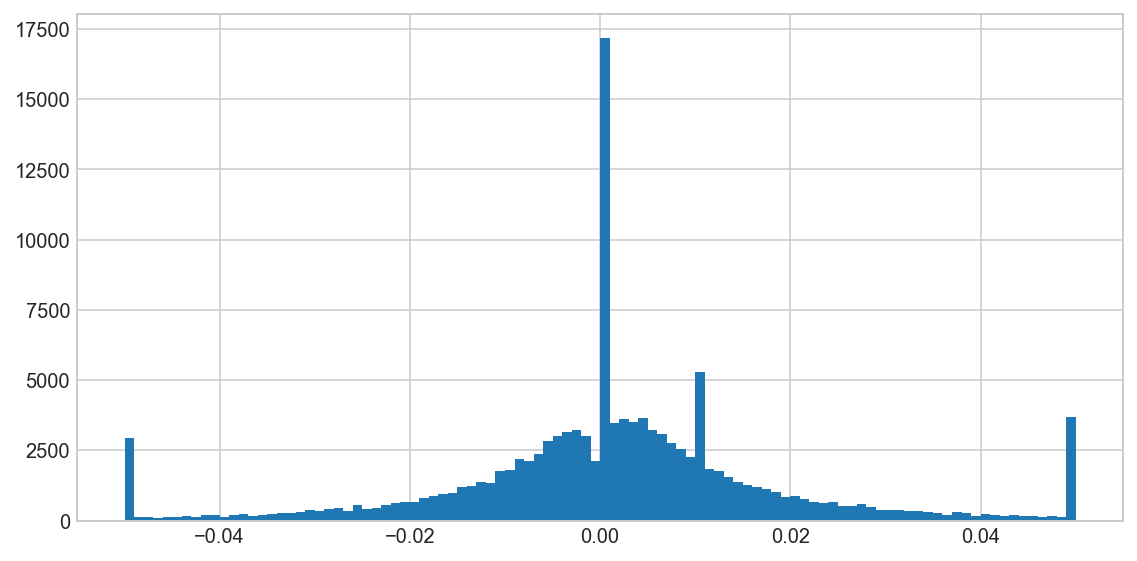

In [23]:
raw['target'].clip(-0.05, 0.05).hist(bins=100);

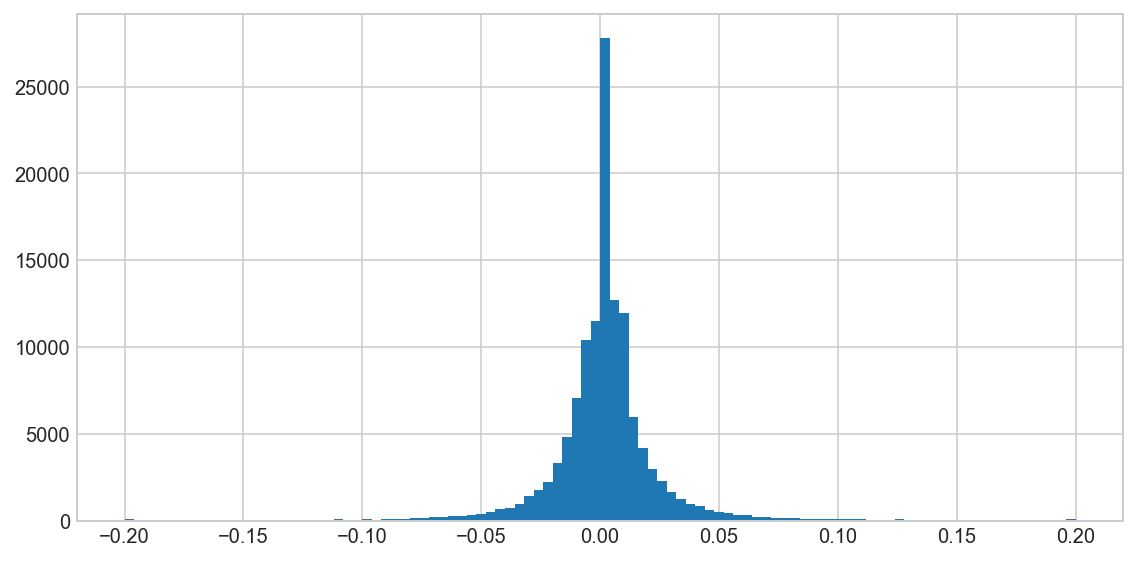

In [24]:
raw['target'].clip(-0.2, 0.2).hist(bins=100);

#### COLUMN 'lastactive'

In [25]:
# for each cfips, get the last active value and assign it to the NEW column 'lastactive'
raw['last_mbd'] = raw.groupby('cfips')['microbusiness_density'].transform('last')

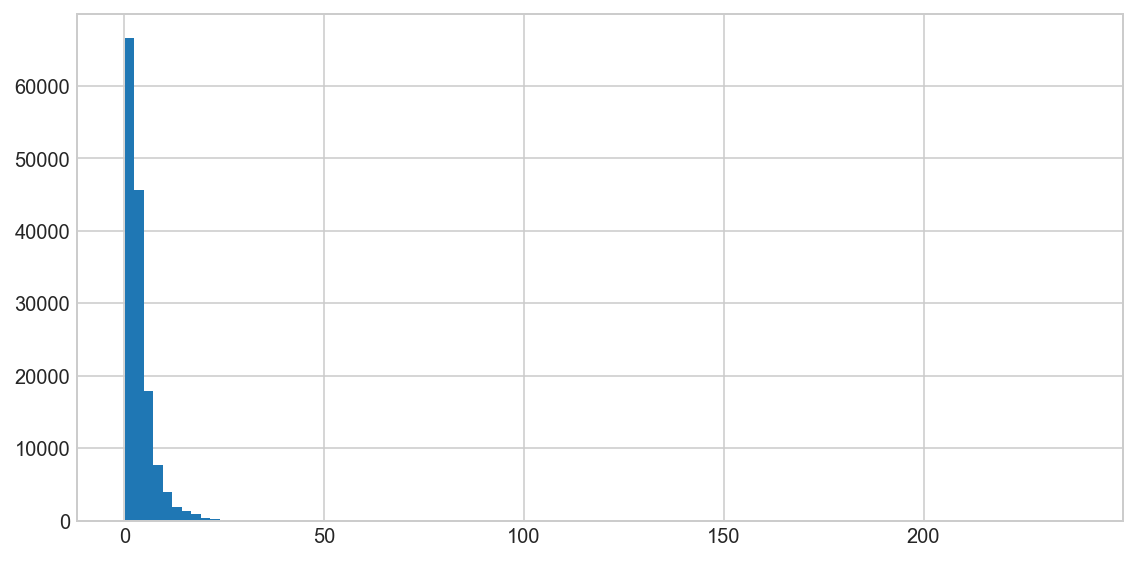

In [26]:
raw['last_mbd'].clip(0, 100000).hist(bins=100);

#### COLUMN 'lasttarget'

In [27]:
# for each cfips, get dcount=28 (2021-12-01)'s density, so we get
#   cfips    2021-12-01's density
#   1001      3.286307
#   1003      7.930010
#         ...
# dt is a mapping table for the next step
dt = (raw
      .loc[raw.dcount == 30]
      .groupby('cfips')['active']
      .agg('last')
     )

# basically, use each cfips' 2021-12-01 density as the value for 'lasttarget' column 
# NOTE: this is the actual density value! not the target value. why 28?
raw['last_target'] = raw['cfips'].map(dt)

In [30]:
raw.head(3)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,...,state_i,cpi_monthly,treasury10y,pct_unemployment,population,act_lag_1,act_var,target,last_mbd,last_target
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1186.02,0,2019,8,...,0,0.1,2.007,2.9,41527,1186.02,0.000000,0.010101,3.470915,1417.0
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.00,0,2019,9,...,0,0.2,1.499,2.9,41527,1186.02,0.010101,0.059265,3.470915,1417.0
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.00,0,2019,10,...,0,0.3,1.668,3.0,41527,1198.00,0.059265,-0.020489,3.470915,1417.0


### 4. Feature Engineering

In [31]:
def build_features(raw, target='active', target_mbd='microbusiness_density', lags = 6):
    '''
    e.g.,
    target = 'target'
    target_act = 'microbusiness_density'
    lags = 4
    '''
    
    feats = []
    for lag in range(1, lags):  # 1 ~ 3
        
        # for each cfips, shift the 'target' column by 1,2 and 3
        # the original 'target' column has values from 0 to 37, note that dcount = 38 (2022-10-01) doesn't have a target value 
        raw[f'act_lag_{lag}'] = raw.groupby('cfips')[target].shift(lag)
        
        # for each cfips, the diff between the current avtive value and the previous 1,2,and 3 months' active values
        # the original 'active' column has values from 0 to 38
        raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')[target_mbd].diff(lag)
        
        # the shifted 'target' and 'active' are taken as features
        # basically, for each month, the previous 1,2,3 months' target and active are taken into consideration
        feats.append(f'act_lag_{lag}')
        feats.append(f'mbd_lag_{lag}')
    
    # the sum of the previous 2,4,6 months 'target' value
    lag = 1
    for window in [2, 4, 6]:
        raw[f'act_rollmea{window}_{lag}'] = (raw
                                             .groupby('cfips')[f'act_lag_{lag}']
                                             .transform(lambda s: s.rolling(window, min_periods=1).sum())
                                            )
        
        ## the diff between the previous month and the sum of previous 6 months. the original notebook doesn't use it
        ##raw[f'mbd_rollmea{window}_{lag}'] = raw[f'mbd_lag_{lag}'] - raw[f'mbd_rollmea{window}_{lag}']
        feats.append(f'act_rollmea{window}_{lag}')
        
    for window in [1, 2, 3]:
        raw[f'cpi_rollmea{window}_{lag}'] = (raw
                                             .groupby('cfips')['cpi_monthly']
                                             .transform(lambda s: s.rolling(window, min_periods=1).sum())
                                            )

        
        feats.append(f'cpi_rollmea{window}_{lag}')
    
    for window in [2, 4, 6]:
        raw[f'unmp_rollmea{window}_{lag}'] = (raw
                                             .groupby('cfips')['pct_unemployment']
                                             .transform(lambda s: s.rolling(window, min_periods=1).sum())
                                            )


        feats.append(f'unmp_rollmea{window}_{lag}')

        
    return raw, feats

In [32]:
# Build Features based in lag of target
raw, feats = build_features(raw, 'target', 'microbusiness_density', lags = 4)

# the state code is a feature
features = ['state_i']
features += feats
print(features)

raw.loc[raw.dcount == 40, features].head(10)

['state_i', 'act_lag_1', 'mbd_lag_1', 'act_lag_2', 'mbd_lag_2', 'act_lag_3', 'mbd_lag_3', 'act_rollmea2_1', 'act_rollmea4_1', 'act_rollmea6_1', 'cpi_rollmea1_1', 'cpi_rollmea2_1', 'cpi_rollmea3_1', 'unmp_rollmea2_1', 'unmp_rollmea4_1', 'unmp_rollmea6_1']


,state_i,act_lag_1,mbd_lag_1,act_lag_2,mbd_lag_2,act_lag_3,mbd_lag_3,act_rollmea2_1,act_rollmea4_1,act_rollmea6_1,cpi_rollmea1_1,cpi_rollmea2_1,cpi_rollmea3_1,unmp_rollmea2_1,unmp_rollmea4_1,unmp_rollmea6_1
38,0,0.006152,0.021178,0.005498,0.040004,-0.004107,0.025885,0.011650,0.034969,0.027467,0.5,0.9,1.1,5.3,10.5,15.8
85,0,0.002170,0.018098,-0.017601,-0.131351,-0.009601,-0.213665,-0.015431,-0.017278,0.049618,0.5,0.9,1.1,5.3,10.5,15.8
132,0,0.020921,0.025247,0.008439,0.035346,-0.016598,0.015149,0.029359,0.033948,0.033966,0.5,0.9,1.1,5.3,10.5,15.8
179,0,-0.021368,-0.028106,0.017391,-0.005621,-0.025424,-0.039348,-0.003976,0.010248,0.028286,0.5,0.9,1.1,5.3,10.5,15.8
226,0,-0.010949,-0.020278,0.008589,-0.004506,0.002460,0.000000,-0.002360,0.033137,0.038372,0.5,0.9,1.1,5.3,10.5,15.8
273,0,0.012987,0.012668,0.013158,0.025336,0.013333,0.038004,0.026145,0.052992,0.080770,0.5,0.9,1.1,5.3,10.5,15.8
320,0,0.009036,0.019576,0.027864,0.078303,0.031949,0.143556,0.036900,0.098454,0.171279,0.5,0.9,1.1,5.3,10.5,15.8
367,0,-0.003180,-0.008933,0.007609,0.012283,0.002006,0.017866,0.004429,0.027747,0.034010,0.5,0.9,1.1,5.3,10.5,15.8
414,0,-0.040201,-0.060421,-0.012407,-0.079302,-0.017073,-0.105736,-0.052608,-0.015697,-0.023285,0.5,0.9,1.1,5.3,10.5,15.8
461,0,-0.012605,-0.014264,0.000000,-0.014264,-0.008333,-0.023773,-0.012605,0.000338,-0.098884,0.5,0.9,1.1,5.3,10.5,15.8


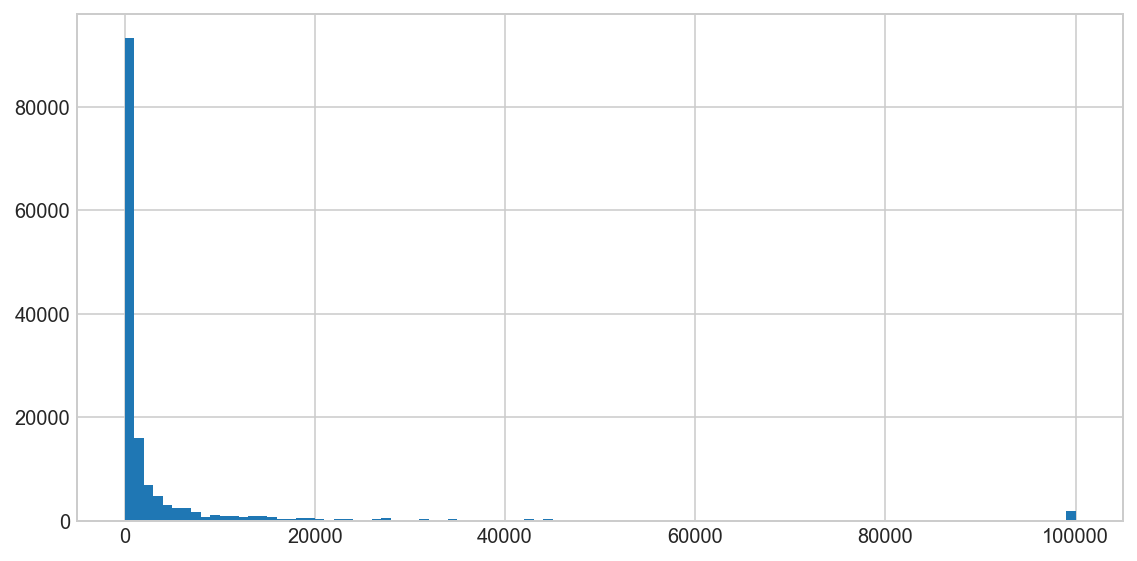

In [33]:
# why do we have to care about 'lasttarget'?
# ' basically, use each cfips' 2021-12-01 density as the value for 'lasttarget' column 
#   NOTE: this is the actual density value! not the target value. why 28?'
raw['last_target'].clip(0,100000).hist(bins=100);

### 5. Model

What's the meaning of the blacklist? how to get it? see section 6

In [34]:
blacklist_new = ['North Dakota', 'Kansas', 'Nebraska', 'Vermont', 'Alaska', 'South Dakota']

blacklistcfips_new = [
1027,1035,1049,1067,1071,1075,1077,1101,1105,1107,1131,1133,2013,2060,2100,2105,2110,2164,2180,2185,2195,2198,2220,2230,
2282,4001,4012,4013,5003,5005,5011,5025,5027,5031,5039,5041,5047,5063,5077,5081,5093,5095,5099,5107,5109,5117,5121,5129,
5133,5141,5145,6003,6005,6015,6027,6033,6035,6051,6053,6093,6095,6109,6115,8003,8007,8009,8019,8021,8027,8049,8053,8055,
8057,8061,8083,8091,8099,8103,8105,8109,8111,8115,8117,9007,10003,12017,12019,12029,12043,12061,12073,12075,12099,12127,
13005,13007,13017,13023,13027,13043,13055,13075,13117,13123,13125,13143,13147,13161,13167,13171,13193,13199,13209,13213,
13225,13231,13239,13243,13249,13251,13259,13287,13307,13315,13319,15005,15007,16007,16013,16025,16029,16031,16033,16035,
16039,16045,16047,16061,16067,16077,17001,17003,17009,17013,17015,17021,17033,17045,17051,17061,17063,17065,17067,17069,
17077,17085,17103,17105,17115,17117,17147,17159,17167,17169,17171,17173,17175,17177,17189,17191,18007,18009,18017,18019,
18021,18035,18037,18049,18051,18083,18087,18091,18111,18127,18129,18137,18139,18153,18159,18171,19005,19007,19017,19027,
19031,19033,19035,19037,19039,19041,19045,19051,19053,19055,19059,19067,19069,19071,19077,19081,19093,19097,19099,19105,
19107,19111,19113,19115,19125,19143,19151,19157,19161,19165,19181,19185,19191,19195,20005,20009,20011,20017,20019,20023,
20025,20029,20033,20035,20037,20039,20043,20047,20049,20053,20057,20063,20065,20067,20069,20071,20073,20075,20081,20083,
20097,20101,20105,20111,20115,20125,20129,20135,20139,20143,20145,20147,20149,20153,20161,20167,20171,20177,20179,20183,
20185,20187,20189,20191,20193,20195,20199,20203,20205,20207,21003,21019,21025,21037,21039,21045,21047,21055,21073,21077,
21091,21095,21105,21125,21129,21133,21135,21141,21143,21145,21149,21159,21187,21191,21193,21199,21201,21203,21215,21217,
21227,21237,21239,22003,22007,22011,22015,22021,22035,22047,22053,22059,22089,22091,22103,22123,22127,23003,23009,23021,
23027,24015,24029,24031,24039,25011,26003,26007,26023,26025,26029,26041,26043,26051,26061,26079,26083,26089,26095,26097,
26101,26103,26111,26117,26127,26129,26131,26141,26143,26159,26161,27005,27011,27013,27017,27021,27023,27029,27037,27047,
27055,27065,27069,27073,27077,27079,27083,27101,27103,27105,27125,27135,27145,27147,27149,27159,27167,27169,28009,28017,
28019,28035,28061,28063,28099,28125,28147,28155,28157,29001,29005,29007,29019,29029,29037,29045,29049,29051,29057,29063,
29065,29069,29073,29089,29101,29109,29121,29123,29125,29133,29135,29137,29143,29151,29159,29161,29167,29173,29175,29177,
29179,29181,29183,29195,29199,29203,29209,29211,29213,29217,29223,29227,30005,30009,30025,30033,30035,30037,30045,30049,
30055,30059,30067,30069,30071,30073,30079,30085,30087,30089,30093,30101,30103,30105,30107,30109,31003,31005,31007,31011,
31017,31019,31031,31041,31047,31049,31053,31057,31059,31063,31065,31069,31071,31073,31075,31077,31085,31087,31091,31093,
31103,31107,31111,31113,31127,31129,31131,31133,31135,31139,31143,31145,31149,31151,31159,31161,31163,31169,31171,31173,
31175,31177,31179,31181,31185,32001,32005,32009,32017,32023,32027,32029,32510,34017,34021,35003,35011,35015,35021,35023,
35027,35033,35039,35043,35047,35049,35051,35053,35057,36021,36033,36041,36055,36057,36067,36091,36107,36109,36113,36115,
36123,37009,37011,37017,37029,37095,37115,37117,37131,37149,37187,37197,38003,38005,38007,38009,38013,38021,38023,38027,
38031,38033,38037,38039,38041,38043,38047,38051,38057,38067,38073,38075,38083,38087,38089,38095,38097,38101,39007,39009,
39017,39019,39027,39037,39039,39053,39067,39087,39105,39111,39113,39119,39121,39125,39129,39157,39167,40001,40013,40023,
40025,40027,40029,40039,40043,40045,40057,40067,40081,40085,40099,40101,40105,40115,40123,40127,40129,40133,40141,41007,
41011,41013,41015,41021,41031,41041,41043,41051,41055,42009,42011,42013,42019,42023,42067,42071,42083,42099,42105,42111,
44005,44009,45005,45025,45031,45061,45069,46003,46009,46015,46017,46019,46021,46023,46037,46039,46041,46043,46045,46051,
46053,46055,46057,46059,46063,46065,46067,46069,46071,46073,46075,46079,46085,46089,46097,46099,46105,46107,46109,46111,
46117,46123,46135,47005,47019,47021,47023,47027,47035,47055,47057,47061,47073,47075,47083,47087,47097,47099,47101,47105,
47109,47121,47127,47135,47147,47151,47153,47169,47171,47175,47183,47185,48017,48055,48057,48063,48069,48073,48075,48079,
48095,48101,48103,48105,48107,48109,48115,48117,48129,48131,48133,48137,48151,48153,48155,48173,48175,48177,48191,48197,
48207,48211,48217,48233,48237,48239,48243,48247,48261,48263,48265,48269,48275,48277,48283,48295,48299,48305,48307,48311,
48317,48319,48323,48327,48333,48335,48347,48357,48369,48371,48393,48401,48413,48417,48419,48421,48435,48443,48447,48453,
48457,48461,48463,48465,48469,48475,48501,48503,49009,49027,49039,50003,50009,50013,50017,50019,50025,50027,51009,51025,
51029,51031,51043,51051,51059,51077,51079,51091,51097,51101,51103,51113,51115,51119,51121,51137,51139,51147,51159,51171,
51173,51183,51197,51530,51600,51610,51678,51735,51810,51830,53001,53019,53023,53031,53033,53037,53039,53047,53051,53065,
53069,53071,54013,54025,54027,54031,54033,54041,54043,54049,54059,54065,54071,54073,54085,54091,54099,55003,55007,55011,
55025,55039,55041,55049,55051,55061,55065,55069,55078,55091,55103,55115,55117,55119,55123,55127,55131,56001,56009,56015,
56019,56027,56031,56045,
]

blacklistcfips_new2 = [
1003,1019,1027,1029,1035,1039,1045,1049,1057,1067,1071,1075,1077,1091,1099,1101,1103,1105,1107,1129,1131,1133,2013,2016,
2060,2070,2100,2105,2110,2122,2130,2164,2180,2185,2188,2195,2198,2220,2230,2275,2282,4001,4009,4012,4013,4021,5001,5003,
5005,5011,5013,5019,5025,5027,5029,5031,5035,5039,5041,5043,5047,5063,5065,5071,5077,5079,5081,5083,5091,5093,5095,5097,
5099,5107,5109,5115,5117,5121,5125,5127,5129,5133,5135,5137,5139,5141,5145,5147,6003,6005,6009,6015,6021,6027,6033,6035,
6037,6051,6053,6055,6061,6063,6069,6079,6081,6093,6095,6097,6105,6109,6115,8003,8005,8007,8009,8013,8019,8021,8025,8027,
8049,8051,8053,8055,8057,8061,8065,8067,8069,8071,8073,8075,8079,8083,8091,8099,8103,8105,8107,8109,8111,8113,8115,8117,
8121,8125,9005,9007,9009,10003,12001,12009,12013,12017,12019,12029,12043,12055,12061,12065,12073,12075,12079,12087,12099,
12123,12127,13005,13007,13015,13017,13019,13023,13027,13035,13037,13043,13047,13055,13057,13063,13065,13075,13091,13101,
13105,13107,13117,13119,13121,13123,13125,13127,13135,13141,13143,13147,13149,13157,13161,13167,13169,13171,13193,13199,
13201,13205,13209,13213,13219,13225,13229,13231,13233,13237,13239,13243,13247,13249,13251,13253,13257,13259,13265,13273,
13281,13287,13289,13291,13293,13299,13301,13307,13309,13315,13319,15005,15007,16007,16013,16023,16025,16029,16031,16033,
16035,16039,16045,16047,16049,16061,16067,16069,16077,16081,17001,17003,17007,17009,17013,17015,17019,17021,17031,17033,
17045,17047,17051,17059,17061,17063,17065,17067,17069,17071,17075,17077,17079,17083,17085,17089,17091,17095,17101,17103,
17105,17107,17109,17115,17117,17123,17127,17133,17137,17143,17147,17151,17155,17159,17161,17167,17169,17171,17173,17175,
17177,17179,17185,17189,17191,17193,17203,18003,18007,18009,18013,18017,18019,18021,18027,18035,18037,18039,18041,18049,
18051,18053,18055,18059,18065,18073,18075,18079,18083,18085,18087,18091,18103,18107,18111,18113,18115,18125,18127,18129,
18133,18135,18137,18139,18143,18145,18151,18153,18159,18161,18165,18171,18177,18179,19001,19003,19005,19007,19011,19013,
19017,19019,19027,19031,19033,19035,19037,19039,19041,19045,19051,19053,19055,19059,19061,19067,19069,19071,19073,19077,
19081,19083,19089,19093,19097,19099,19101,19105,19107,19111,19113,19115,19125,19127,19141,19143,19145,19149,19151,19155,
19157,19161,19165,19169,19175,19177,19179,19181,19185,19191,19195,20005,20007,20009,20011,20017,20019,20023,20025,20029,
20033,20035,20037,20039,20043,20047,20049,20053,20057,20061,20063,20065,20067,20069,20071,20073,20075,20081,20083,20093,
20097,20099,20101,20105,20109,20111,20113,20115,20117,20123,20125,20129,20135,20137,20139,20143,20145,20147,20149,20151,
20153,20157,20161,20163,20167,20169,20171,20177,20179,20183,20185,20187,20189,20191,20193,20195,20197,20199,20203,20205,
20207,21001,21003,21013,21017,21019,21023,21025,21027,21029,21033,21035,21037,21039,21045,21047,21051,21053,21055,21057,
21059,21061,21063,21073,21075,21077,21081,21091,21093,21095,21099,21103,21105,21109,21115,21117,21119,21121,21125,21129,
21131,21133,21135,21137,21141,21143,21145,21147,21149,21153,21159,21161,21165,21169,21175,21179,21187,21189,21191,21193,
21197,21199,21201,21203,21205,21215,21217,21221,21227,21235,21237,21239,22001,22003,22007,22011,22015,22021,22023,22031,
22035,22041,22047,22051,22053,22057,22059,22069,22089,22091,22103,22109,22121,22123,22127,23003,23005,23009,23013,23021,
23027,24015,24027,24029,24031,24035,24039,24041,24510,25003,25007,25011,25015,26003,26007,26011,26019,26021,26023,26025,
26027,26029,26033,26037,26041,26043,26045,26047,26051,26059,26061,26065,26071,26079,26083,26089,26095,26097,26101,26103,
26105,26111,26115,26117,26119,26125,26127,26129,26131,26141,26143,26155,26159,26161,27001,27005,27011,27013,27017,27019,
27021,27023,27025,27027,27029,27031,27037,27043,27047,27051,27053,27055,27063,27065,27069,27073,27075,27077,27079,27083,
27087,27091,27095,27099,27101,27103,27105,27111,27113,27119,27123,27125,27131,27133,27135,27139,27143,27145,27147,27149,
27155,27159,27165,27167,27169,28003,28007,28009,28013,28017,28019,28021,28023,28025,28035,28041,28045,28055,28061,28063,
28069,28087,28091,28099,28125,28129,28135,28139,28141,28147,28149,28155,28157,29001,29005,29007,29009,29013,29015,29017,
29019,29023,29029,29033,29037,29041,29045,29049,29051,29053,29055,29057,29059,29061,29063,29065,29067,29069,29073,29075,
29085,29089,29097,29101,29109,29115,29121,29123,29125,29129,29133,29135,29137,29139,29143,29147,29151,29159,29161,29167,
29171,29173,29175,29177,29179,29181,29183,29185,29195,29197,29199,29203,29209,29211,29213,29217,29223,29227,29229,30005,
30009,30011,30015,30025,30027,30033,30035,30037,30041,30045,30049,30053,30055,30059,30067,30069,30071,30073,30077,30079,
30083,30085,30087,30089,30091,30093,30101,30103,30105,30107,30109,31001,31003,31005,31007,31009,31011,31013,31015,31017,
31019,31023,31027,31031,31037,31039,31041,31047,31049,31051,31053,31057,31059,31063,31065,31069,31071,31073,31075,31077,
31085,31087,31091,31093,31095,31097,31103,31107,31111,31113,31115,31125,31127,31129,31131,31133,31135,31139,31143,31145,
31149,31151,31157,31159,31161,31163,31165,31169,31171,31173,31175,31177,31179,31181,31183,31185,32001,32005,32009,32017,
32023,32027,32029,32033,32510,33003,33005,33009,33017,34017,34021,34027,34037,35003,35006,35007,35009,35011,35015,35017,
35021,35023,35027,35033,35035,35037,35039,35043,35047,35049,35051,35053,35057,35059,36011,36013,36017,36021,36033,36041,
36043,36051,36055,36057,36061,36067,36089,36091,36097,36101,36103,36107,36109,36113,36115,36121,36123,37005,37009,37011,
37013,37015,37017,37023,37029,37031,37075,37095,37099,37111,37113,37115,37117,37123,37131,37141,37149,37167,37187,37189,
37193,37197,38001,38003,38005,38007,38009,38013,38017,38021,38023,38027,38029,38031,38033,38037,38039,38041,38043,38045,
38047,38051,38057,38065,38067,38069,38073,38075,38081,38083,38085,38087,38089,38095,38097,38101,38105,39001,39005,39007,
39009,39015,39017,39019,39023,39027,39029,39037,39039,39043,39049,39053,39057,39067,39071,39073,39083,39085,39087,39091,
39097,39105,39107,39111,39113,39117,39119,39121,39123,39125,39129,39135,39143,39151,39153,39157,39159,39163,39167,39173,
40001,40013,40023,40025,40027,40029,40035,40039,40043,40045,40053,40055,40057,40059,40067,40073,40081,40085,40099,40101,
40105,40107,40115,40121,40123,40127,40129,40133,40135,40141,40145,40147,40151,40153,41003,41007,41011,41013,41015,41017,
41021,41023,41025,41027,41031,41033,41037,41041,41043,41051,41055,41057,41061,41063,42005,42009,42011,42013,42015,42017,
42019,42023,42027,42029,42035,42037,42049,42057,42065,42067,42069,42071,42083,42085,42093,42097,42099,42105,42111,42115,
42117,42119,42121,42123,42125,42129,44005,44009,45001,45005,45009,45025,45031,45049,45061,45067,45069,45073,45081,45087,
45089,46003,46005,46007,46009,46011,46013,46015,46017,46019,46021,46023,46029,46031,46037,46039,46041,46043,46045,46047,
46049,46051,46053,46055,46057,46059,46061,46063,46065,46067,46069,46071,46073,46075,46077,46079,46081,46085,46089,46097,
46099,46105,46107,46109,46111,46117,46119,46121,46123,46125,46129,46135,46137,47005,47013,47019,47021,47023,47027,47035,
47039,47051,47055,47057,47059,47061,47073,47075,47083,47087,47095,47097,47099,47101,47103,47105,47109,47111,47121,47127,
47135,47145,47147,47151,47153,47161,47163,47169,47171,47175,47177,47183,47185,48001,48015,48017,48019,48033,48035,48045,
48047,48049,48055,48057,48059,48063,48069,48073,48075,48079,48081,48083,48095,48101,48103,48105,48107,48109,48115,48117,
48119,48123,48125,48127,48129,48131,48133,48137,48151,48153,48155,48159,48165,48171,48173,48175,48177,48179,48191,48195,
48197,48205,48207,48211,48217,48221,48223,48225,48229,48233,48235,48237,48239,48241,48243,48247,48249,48255,48261,48263,
48265,48267,48269,48271,48275,48277,48283,48293,48295,48299,48301,48305,48307,48311,48315,48317,48319,48321,48323,48327,
48333,48335,48343,48345,48347,48351,48357,48369,48371,48373,48375,48377,48379,48385,48389,48393,48401,48403,48405,48413,
48417,48419,48421,48427,48433,48435,48441,48443,48447,48453,48457,48461,48463,48465,48469,48471,48475,48481,48483,48485,
48487,48489,48495,48499,48501,48503,48507,49001,49007,49009,49013,49023,49025,49027,49031,49037,49039,50001,50003,50005,
50007,50009,50011,50013,50015,50017,50019,50025,50027,51009,51015,51025,51029,51031,51037,51043,51047,51051,51059,51065,
51071,51075,51077,51079,51081,51089,51091,51095,51097,51101,51103,51113,51115,51119,51121,51127,51135,51137,51139,51147,
51159,51163,51165,51171,51173,51181,51183,51195,51197,51199,51520,51530,51540,51600,51610,51678,51685,51735,51770,51810,
51830,53001,53013,53019,53023,53031,53033,53035,53037,53039,53041,53047,53051,53065,53069,53071,53077,54001,54005,54013,
54017,54019,54021,54025,54027,54031,54033,54041,54043,54047,54049,54055,54057,54059,54065,54071,54073,54077,54083,54085,
54089,54091,54097,54099,54101,54103,54105,54107,54109,55003,55007,55011,55017,55019,55021,55025,55029,55031,55039,55041,
55043,55047,55049,55051,55061,55065,55069,55071,55075,55077,55078,55085,55091,55097,55099,55101,55103,55109,55115,55117,
55119,55121,55123,55127,55131,56001,56009,56011,56015,56019,56021,56027,56031,56037,56043,56045,
]


In [35]:
print('length "blacklistcfips_new": ', len(blacklistcfips_new))
print('Intersection between "outliers" and "blacklistcfips_new": ', len(set(blacklistcfips_new).intersection(set(outliers))))
print('Intersection between "blacklist states" and "blacklistcfips": ', len(set(raw.loc[raw.state.isin(blacklist_new), 'cfips'].unique()).intersection(set(blacklistcfips_new))))

length "blacklistcfips_new":  898
Intersection between "outliers" and "blacklistcfips_new":  218
Intersection between "blacklist states" and "blacklistcfips":  187


In [38]:
# threshold
ACT_THR = 18
ABS_THR = 0.6

# define 3 new columns for use
raw['ypred_last'] = np.nan
raw['ypred'] = np.nan
raw['k'] = 1.0

VAL = []
BEST_ROUNDS = []

In [39]:
for TS in range(31, 40):  # from 29 to 37.  1) is it the reason why 'lasttarget' use 'dcount=28'?  
                          # the actual density pred you give is 30 to 38  
    print(TS)
    
    # --- define the model
    model = xgb.XGBRegressor(
        objective='reg:pseudohubererror',   # why this objective?
        #objective='reg:squarederror',
        tree_method="hist",                 # 
        n_estimators=4999,                  # iterations
        learning_rate=0.0075,
        max_leaves=31,    
        subsample=0.60,                     # sample used for each iteration
        colsample_bytree=0.50,              # features used for each iteration
        max_bin=4096,                       # 
        n_jobs=2,
        eval_metric='mae',                  # 
        early_stopping_rounds=70,
    )
    
    # --- get training data
    train_indices = (raw.istest == 0) & (raw.dcount < TS) & (raw.dcount >= 1) & (raw.last_mbd > ABS_THR) & (raw.last_target > ACT_THR)
    #                no test data   |    training month = [1,TS)             |                   1.8     |                    1
    #                                    why not use 0?                                                              
    #                                    because has undefined features, but does 1 has all the features?
    # 
    # note that for each cfips, the 'lastactive' across months are the same, so does the 'lasttarget' column
    # so, you either select all the rows or drop all the row for a cfips
    #
    # ‘lasttarget’: for each cfips, the density in dcount = 28 '2021-12-01'
    # 'lastactive': for each cfips, the last active value (in dcount = 38)  '2022-10-01'
    
    # --- get testing data
    valid_indices = (raw.istest==0) & (raw.dcount == TS)  # note: more cfips than training data, but we exclude some of them later
    
    # --- model fit
    model.fit(
        raw.loc[train_indices, features],
        raw.loc[train_indices, 'target'].clip(-0.0043, 0.0045),    # why clip ? the increase or decrease is confined in the range (-0.0043, 0.0045). reasonable?
        eval_set=[(raw.loc[valid_indices, features], raw.loc[valid_indices, 'target'])],
        verbose=500,
    )
    
    # --- save best iteration
    best_rounds = model.best_iteration
    BEST_ROUNDS.append(model.best_iteration)
    
    # --- pred the current validation set, note the pred is the increment comparing to TS+1
    ypred = model.predict(raw.loc[valid_indices, features])
    
    # becasue we pred the increment for the next month, so we need to add 1
    raw.loc[valid_indices, 'k'] = ypred + 1
    # if you multiple it with 'density' in TS, you get next month TS+1 density prediction
    raw.loc[valid_indices, 'k'] = raw.loc[valid_indices,'k'] * raw.loc[valid_indices,'active']

    # --- ACTUALLY, WE ARE PREDICTING **TS+1** ---
    # 1. define two mappings, lastval and dt
    
    lastval = (raw
               .loc[raw.dcount == TS, ['cfips', 'active']]
               .set_index('cfips')
               .to_dict()['active']
              )
    
    # for all the current validation TS, get cfips and density
    # then, set cfips to index, so we make a dict -> cfips: the density for TS
    # e.g., { 'microbusiness_density':{1001: 3.2967808, 1003: 7.733397, 1005: 1.1866289, ...} }
    # this is a map for later use
    
    dt = (raw
          .loc[raw.dcount == TS, ['cfips', 'k']]
          .set_index('cfips')
          .to_dict()['k']
         )
    
    # e.g., { 'k':{1001: pred for TS+1 month ACTUAL density, 1003: , 1005: , ...} }
    # this is a map for later use
    
    # 2. define a tmp dataframe for the preds of TS+1
    
    df = (raw
          .loc[raw.dcount == (TS+1), ['cfips', 'active', 'state', 'last_mbd', 'act_lag_1']]
          .reset_index(drop=True)
         )
    
    # get all the cfips's TS+1 the 2022-10-01 active |  'target' value in TS
    
    # ATTACH the mappings to df columns
    df['pred'] = df['cfips'].map(dt)         # put TS+1 density pred to 'pred' column of the TS+1 specific df
    df['lastval'] = df['cfips'].map(lastval) # put the TS density to 'lastval' column of df
    
    # FOR SOME CASES, WE DON'T WANT TO USE THE PREDICTIONS BY THE MODEL, INSTEAD, WE WANT TO USE THE TS DENSITY.
    # case1. for each cfips, if the last active in dcount=38 is smaller than ACT_THR, (which means the business scale is considered as small)
    #    then, we don't use the pred above, instead, use the TS density
    df.loc[df['last_mbd'] <= ABS_THR, 'pred'] = df.loc[df['last_mbd'] <= ABS_THR, 'lastval']
    
    # case2. for each cfips, if the TS actual density is smaller than ABS_THR, (which means the recent trend is small?)
    #    then, we don't use the pred above, instead, use the TS density
    df.loc[df['lastval'] <= ACT_THR, 'pred'] = df.loc[df['lastval'] <= ACT_THR, 'lastval']
    
    # case3. if the state is in the black list, then we don't use the pred above, instead, use the TS density
    #        how to get this blacklist?
    df.loc[df['state'].isin(blacklist_new), 'pred'] = df.loc[df['state'].isin(blacklist_new), 'lastval']
    
    # case4. if the cfips is in the black list, then we don't use the pred above, instead, use the TS density
    df.loc[df['cfips'].isin(blacklistcfips_new), 'pred'] = df.loc[df['cfips'].isin(blacklistcfips_new), 'lastval']
    
    # FINALLY, assign the pred to the 'ypred' column of the 'raw' dataframe
    raw.loc[raw.dcount == (TS+1), 'ypred'] = df['pred'].values
    #          lastval is the actual density in TS, basically, you shift lag=1
    raw.loc[raw.dcount == (TS+1), 'ypred_last'] = df['lastval'].values
    
    print(f'TS: {TS}')
    print('Last Value SMAPE:', smape(df['active'], df['lastval']) )   # smape if you simply use last density to predict TS+1
    print('XGB SMAPE:', smape(df['active'], df['pred']))              # smape if you use the preds
    print()

ind = (raw.dcount >= 32) & (raw.dcount <= 40)
print( 'XGB SMAPE:', smape( raw.loc[ind, 'active'],  raw.loc[ind, 'ypred'] ) )
print( 'Last Value SMAPE:', smape( raw.loc[ind, 'active'],  raw.loc[ind, 'ypred_last'] ) )

31
[0]	validation_0-mae:0.49316
[500]	validation_0-mae:0.01490
[1000]	validation_0-mae:0.01114
[1500]	validation_0-mae:0.01113
[1974]	validation_0-mae:0.01113
TS: 31
Last Value SMAPE: 1.1258309369453439
XGB SMAPE: 1.1083204319982065

32
[0]	validation_0-mae:0.49995
[500]	validation_0-mae:0.01651
[1000]	validation_0-mae:0.00901
[1500]	validation_0-mae:0.00894
[1679]	validation_0-mae:0.00894
TS: 32
Last Value SMAPE: 0.8979693755942282
XGB SMAPE: 0.8999538215052328

33
[0]	validation_0-mae:0.48938
[500]	validation_0-mae:0.01487
[710]	validation_0-mae:0.01324
TS: 33
Last Value SMAPE: 1.3749182789328496
XGB SMAPE: 1.264930763460961

34
[0]	validation_0-mae:0.47741
[500]	validation_0-mae:0.01584
[514]	validation_0-mae:0.01622
TS: 34
Last Value SMAPE: 2.1905474826358557
XGB SMAPE: 1.3249889556486003

35
[0]	validation_0-mae:0.50121
[500]	validation_0-mae:0.02001
[1000]	validation_0-mae:0.01278
[1500]	validation_0-mae:0.01267
[1590]	validation_0-mae:0.01266
TS: 35
Last Value SMAPE: 1.279793583

In [44]:
raw['error'] = vsmape(raw['active'], raw['ypred'])
raw['error_last'] = vsmape(raw['active'], raw['ypred_last'])
raw.loc[(raw.dcount==40), ['cfips', 'active', 'ypred', 'ypred_last','error', 'error_last'] ].head(10)

,cfips,active,ypred,ypred_last,error,error_last
40,1001,1475.0,1467.593082,1463.0,0.503428,0.816882
87,1003,14133.0,14189.662787,14145.0,0.400123,0.084872
134,1005,248.0,247.805754,247.0,0.078356,0.404040
181,1007,229.0,227.721190,227.0,0.559996,0.877193
228,1009,822.0,817.545476,815.0,0.543385,0.855223
275,1011,81.0,80.256405,80.0,0.922252,1.242236
322,1013,337.0,336.084398,335.0,0.272062,0.595238
369,1015,2500.0,2500.738201,2493.0,0.029524,0.280393
416,1017,390.0,390.191493,389.0,0.049089,0.256739
463,1019,241.0,239.728971,239.0,0.528792,0.833333


In [45]:
# select pred indices
ind = (raw.dcount >= 32) & (raw.dcount <= 40)

# calculate microbusiness_density using the "active" predicted
raw['mbd_pred'] = 100 * raw['ypred'] / raw['population']
raw['mbd_last'] = 100 * raw['ypred_last'] / raw['population']

# As we scaled the "active" feature, we as have to scale the "microbusiness_density"
raw['mbd_orig_scaled'] = 100 * raw['active'] / raw['population']

print( 'XGB SMAPE (mbd):', smape( raw.loc[ind, 'mbd_orig_scaled'],  raw.loc[ind, 'mbd_pred'] ) )
print( 'Last Value SMAPE (mbd):', smape( raw.loc[ind, 'mbd_orig_scaled'],  raw.loc[ind, 'mbd_last'] ) )

XGB SMAPE (mbd): 1.2093906009140374
Last Value SMAPE (mbd): 1.3319328545102658


In [ ]:
# raw.head(50)

### 6. Some post-hoc analysis after training and validation

#### 6.1 which state has the most significant diff between the error (by pred) and the error_last (by last value pred)

for example, it is better to use the actual xgb prediction for the district of columbia, instead of the last prediction.

In [46]:
dt = raw.loc[(raw.dcount>=32) & (raw.dcount<=40)].groupby('state')[['error', 'error_last']].mean()
dt['hit'] = dt['error'] - dt['error_last']
dt = dt.sort_values('hit', ascending=True)
dt

,error,error_last,hit
state,,,
District of Columbia,0.206996,0.503436,-0.296439
Florida,0.913642,1.121246,-0.207604
North Carolina,0.920703,1.116323,-0.195620
South Carolina,0.972656,1.165499,-0.192843
Delaware,1.726650,1.914935,-0.188286
Maryland,0.633574,0.816877,-0.183303
New Jersey,0.445485,0.626867,-0.181381
New Hampshire,0.406037,0.585963,-0.179927
Arizona,0.617509,0.792698,-0.175189


#### 6.2 which month has the biggest error

In [47]:
dt = raw.loc[(raw.dcount >= 32) & (raw.dcount <= 40)].groupby('dcount')[['error', 'error_last']].mean()
dt['hit'] = dt['error'] - dt['error_last']
dt = dt.sort_values('hit', ascending=False)
dt.loc[dt['hit'] > 0]
dt

,error,error_last,hit
dcount,,,
33,0.899954,0.897969,0.001984
36,1.274597,1.279794,-0.005197
39,1.088050,1.093695,-0.005645
32,1.108320,1.125831,-0.017511
38,1.068646,1.101119,-0.032473
37,1.001448,1.034315,-0.032867
40,1.853581,1.889207,-0.035626
34,1.264931,1.374918,-0.109988
35,1.324989,2.190547,-0.865559


#### 6.3 Counties with the biggest mean errors across all prediction period

In [48]:
dt = raw.loc[(raw.dcount >= 32) & (raw.dcount <= 40)].groupby(['state','cfips'])[['ypred','error', 'error_last']].mean()
dt['hit'] = dt['error'] - dt['error_last']
dt = dt.sort_values('hit', ascending=False)
dt = dt.loc[dt['hit'] > -0.13]
dt = dt.reset_index()
dt
# dt.hit.clip(None, -0.13).hist(bins=100)

,state,cfips,ypred,error,error_last,hit
0,Virginia,51195,409.262994,1.423694,1.250868,0.172826
1,Kentucky,21061,53.613127,2.384736,2.215924,0.168812
2,Georgia,13309,52.280140,1.858168,1.712478,0.145690
3,Kentucky,21057,76.917445,2.138931,2.023771,0.115160
4,Missouri,29009,482.118240,1.034797,0.922092,0.112705
...,...,...,...,...,...,...
1591,Arkansas,5035,549.661080,1.230776,1.359918,-0.129142
1592,Michigan,26011,268.035188,0.907732,1.036913,-0.129181
1593,South Carolina,45037,723.692915,0.886135,1.015569,-0.129434
1594,West Virginia,54007,93.188829,1.423958,1.553464,-0.129506


In [49]:
print('cfips in black list states: ')
len(raw.loc[raw.state.isin(['North Dakota', 'Iowa', 'Kansas', 'Nebraska', 'South Dakota','New Mexico', 'Alaska', 'Vermont']), 'cfips'].unique())

cfips in black list states: 


488

In [50]:
# list of cfips that does worse than xgboost
dt = dt.sort_values('cfips')
','.join([str(i) for i in dt.cfips.values])

'1003,1017,1027,1029,1033,1035,1049,1057,1067,1071,1075,1077,1085,1101,1105,1107,1109,1129,1131,1133,2013,2016,2020,2050,2060,2068,2070,2090,2100,2105,2110,2122,2130,2150,2164,2170,2180,2185,2188,2195,2198,2220,2230,2240,2275,2282,2290,4001,4012,4013,5003,5005,5009,5011,5013,5017,5021,5025,5027,5031,5035,5039,5041,5043,5047,5057,5063,5065,5075,5077,5079,5081,5093,5095,5097,5099,5107,5109,5117,5121,5125,5127,5129,5133,5135,5141,5145,6003,6005,6015,6027,6033,6035,6037,6051,6053,6055,6061,6075,6081,6093,6095,6109,6115,8003,8007,8009,8013,8017,8019,8021,8025,8027,8043,8047,8049,8051,8053,8055,8057,8061,8067,8069,8083,8091,8097,8099,8103,8105,8107,8109,8111,8115,8117,8121,8125,9005,9007,9009,9015,10003,12013,12017,12019,12027,12029,12043,12061,12065,12073,12075,12087,12099,12123,12127,12131,13001,13005,13007,13015,13017,13019,13023,13027,13037,13043,13053,13055,13063,13065,13075,13091,13099,13101,13105,13115,13117,13121,13123,13125,13131,13135,13141,13143,13147,13157,13161,13165,13167,13171

<AxesSubplot:>

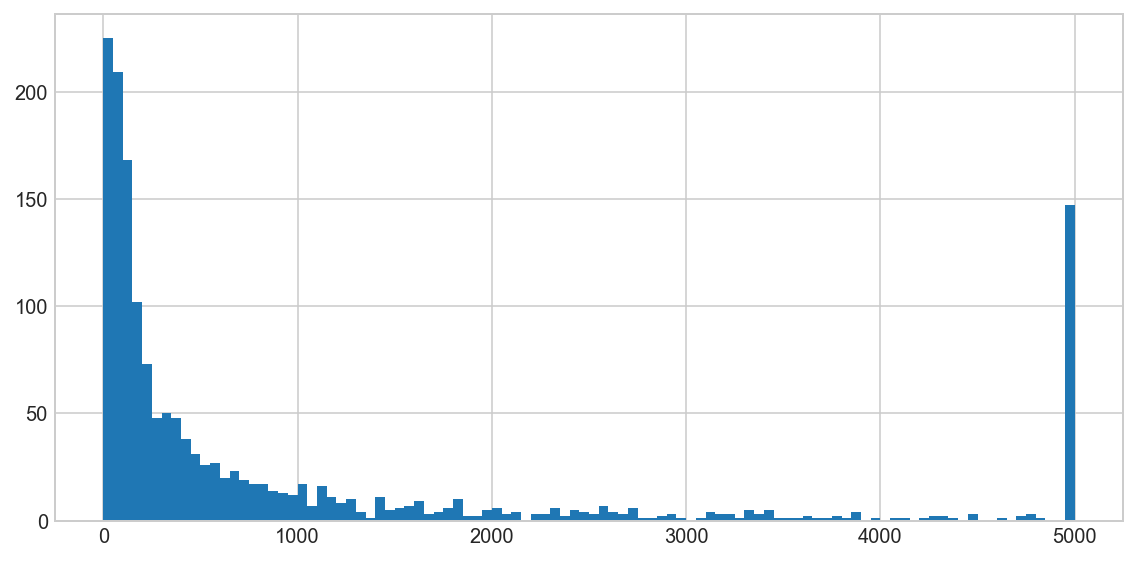

In [51]:
dt.ypred.clip(0, 5000).hist(bins=100)
# plt.xlim(0, )

In [52]:
dt.cfips.values.shape

(1596,)

#### 6.4 Counties that were best in each prediction

In [53]:
dt = raw.loc[(raw.dcount >= 32) & (raw.dcount <= 40), ['cfips', 'error', 'error_last']]
dt['hit'] = dt.error < dt.error_last
dt = dt.groupby('cfips')[['hit']].sum().sort_values('hit', ascending=False)
dt.head(20)

,hit
cfips,
1125,9
48141,9
37067,9
21117,9
28033,9
13285,9
23001,9
28067,9
16021,9


In [ ]:
# # show me the preds, WHY WHERE IS A LAG?????
# for d in dt.index[:5]:
#     raw.loc[raw.cfips==d].plot(x='dcount', y=['microbusiness_density', 'ypred'], title=str(d))
#     #raw.loc[raw.cfips==d].plot(x='dcount', y=['microbusiness_density', 'ypred_last'], title=str(d))

### 7. LET'S GET THE PREDICTIONS FOR TS=38+1, WHICH IS 2022-11-01

In [54]:
np.mean( BEST_ROUNDS ), np.median( BEST_ROUNDS ), BEST_ROUNDS

(1087.2222222222222, 798.0, [1905, 1610, 641, 444, 1520, 679, 798, 1555, 633])

In [55]:
best_rounds = 1087 + 1 #int(np.median( BEST_ROUNDS ) + 1)
best_rounds

1088

In [ ]:
TS = 38
print('TS: ', TS)

model = xgb.XGBRegressor(
    objective='reg:pseudohubererror',
    #objective='reg:squarederror',
    tree_method="hist",
    n_estimators=4999,  # now we have best round, so no early stopping
    learning_rate=0.0075,
    max_leaves = 31,           # the model used above has 17
    subsample=0.60,            # the model used above has 0.50 
    colsample_bytree=0.50,     
    max_bin=4096,
    n_jobs=2,
    eval_metric='mphe',
    early_stopping_rounds=70,
)

train_indices = (raw.istest == 0) & (raw.dcount < TS) & (raw.dcount >= 1) & \
                (raw.last_mbd > ABS_THR) & (raw.last_target > ACT_THR)

valid_indices = (raw.istest==0) & (raw.dcount == TS - 1)


# I don't understand why we need two identical models. and then do a half / half ensemble
print("model:")
model.fit(raw.loc[train_indices, features],
          raw.loc[train_indices, 'target'].clip(-0.0043, 0.0045),
          eval_set=[(raw.loc[valid_indices, features], raw.loc[valid_indices, 'target'])],
          verbose=250)
print("Model best rounds: ", model.best_iteration)

# ypred = model.predict(X_train)

# print(f'TS: {TS}')
# print('Last Value SMAPE:', smape(df['active'], df['lastval']) )   # smape if you simply use last density to predict TS+1
# print('XGB SMAPE:', smape(df['active'], df['pred']))              # smape if you use the preds


In [57]:
TS = 40
print('TS: ', TS)

model0 = xgb.XGBRegressor(
    objective='reg:pseudohubererror',
    #objective='reg:squarederror',
    tree_method="hist",
    n_estimators=best_rounds,  # now we have best round, so no early stopping
    learning_rate=0.0075,
    max_leaves =31,           # the model used above has 17
    subsample=0.6,            # the model used above has 0.50 
    colsample_bytree=0.50,     
    max_bin=4096,
    n_jobs=2,
    eval_metric='mae',
    #early_stopping_rounds=70,
)

model1 = xgb.XGBRegressor(
    objective='reg:pseudohubererror',
    #objective='reg:squarederror',
    tree_method="hist",
    n_estimators=best_rounds,
    learning_rate=0.0075,
    max_leaves =31,
    subsample=0.60,
    colsample_bytree=0.50,
    max_bin=4096,
    n_jobs=2,
    eval_metric='mae',
    #early_stopping_rounds=70,
)

train_indices = (raw.istest == 0) & (raw.dcount < TS) & (raw.dcount >= 1) & (raw.last_mbd > ABS_THR) & (raw.last_target > ACT_THR)
# train_indices = (raw.istest == 0) & (raw.dcount < TS) & (raw.dcount >= 1) & (raw.lastactive>ACT_THR) & (raw.lasttarget>ABS_THR) 
valid_indices = (raw.dcount == TS)
# valid_indices = (raw.dcount == TS)

# I don't understand why we need two identical models. and then do a half / half ensemble
print("model0:")
model0.fit(
    raw.loc[train_indices, features],
    raw.loc[train_indices, 'target'].clip(-0.0044, 0.0046),
    #eval_set=[(raw.loc[valid_indices, features], raw.loc[valid_indices, 'target'])],
    #verbose=250,
)


print("model1:")
model1.fit(
    raw.loc[train_indices, features],
    raw.loc[train_indices, 'target'].clip(-0.0044, 0.0046),
    #eval_set=[(raw.loc[valid_indices, features], raw.loc[valid_indices, 'target'])],
    #verbose=250,
)

ypred = (model0.predict(raw.loc[valid_indices, features]) + model1.predict(raw.loc[valid_indices, features])) / 2

raw.loc[valid_indices, 'k'] = ypred + 1.0
raw.loc[valid_indices,'k'] = raw.loc[valid_indices,'k'] * raw.loc[valid_indices,'active'] # this is the pred for TS+1 = 39, although it is at TS

# 1. define two mappings, lastval and dt
lastval = (raw
           .loc[raw.dcount == TS, ['cfips', 'active']]
           .set_index('cfips')
           .to_dict()['active']
          )

dt = (raw
      .loc[raw.dcount == TS, ['cfips', 'k']]
      .set_index('cfips')
      .to_dict()['k']
     )

# 2. define a temporary dataframe for the preds of TS+1
df = (raw
      .loc[raw.dcount == (TS+1), ['cfips', 'active', 'state', 'last_mbd', 'act_lag_1']]
      .reset_index(drop=True)
     )

# ATTACH the mappings to df columns
df['pred'] = df['cfips'].map(dt)            # put TS+1 density pred to 'pred' column of the TS+1 specific df
df['lastval'] = df['cfips'].map(lastval)    # put the TS density to 'lastval' column of df

# special cases when last_value s better than xgboos prediction
df.loc[df['last_mbd'] <= ABS_THR, 'pred'] = df.loc[df['last_mbd'] <= ABS_THR, 'lastval']
df.loc[df['lastval'] <= ACT_THR, 'pred'] = df.loc[df['lastval'] <= ACT_THR, 'lastval']
df.loc[df['state'].isin(blacklist_new), 'pred'] = df.loc[df['state'].isin(blacklist_new), 'lastval']
df.loc[df['cfips'].isin(blacklistcfips_new), 'pred'] = df.loc[df['cfips'].isin(blacklistcfips_new), 'lastval']


# FINALLY, assign the pred to the 'ypred' column of the 'raw' dataframe
raw.loc[raw.dcount == (TS+1), 'ypred'] = df['pred'].values
raw.loc[raw.dcount == (TS+1), 'ypred_last'] = df['lastval'].values

# special cases
raw.loc[(raw['cfips'] == 28055) & (raw.dcount == 41), 'ypred'] = 0
raw.loc[(raw['cfips'] == 48269) & (raw.dcount == 41), 'ypred'] = 4

# calculate microbusiness_density using the "active" predicted
raw['mbd_pred'] = 100 * raw['ypred'] / raw['population']
raw['mbd_last'] = 100 * raw['ypred_last'] / raw['population']

print(f'TS: {TS}')
print('Last Value SMAPE:', smape(df['active'], df['lastval']) )   # smape if you simply use last density to predict TS+1
print('XGB SMAPE:', smape(df['active'], df['pred']))              # smape if you use the preds



TS:  40
model0:
model1:
TS: 40
Last Value SMAPE: nan
XGB SMAPE: nan


In [62]:
obss = (raw
        .loc[raw.dcount.isin([33,34,35,36,37,38,39,40,41,42,43]), ['dcount', 'first_day_of_month', 'cfips', 'microbusiness_density', 'active',
                                                          'population','ypred_last','ypred','error','error_last','mbd_pred',
                                                          'mbd_last']]
        #.sort_values(['active', 'cfips'], ascending=False)
)
obss.iloc[500:550]

,dcount,first_day_of_month,cfips,microbusiness_density,active,population,ypred_last,ypred,error,error_last,mbd_pred,mbd_last
2153,38,2022-10-01,1091,1.361378,200.0,14691,197.0,197.344537,1.336605,1.511335,1.343302,1.340957
2154,39,2022-11-01,1091,1.361378,200.0,14691,200.0,200.214887,0.107386,0.000000,1.362840,1.361378
2155,40,2022-12-01,1091,1.388605,204.0,14691,200.0,200.646615,1.657439,1.980198,1.365779,1.361378
2156,41,2023-01-01,1091,NaN,NaN,14996,204.0,203.923627,NaN,NaN,1.359853,1.360363
2157,42,2023-02-01,1091,NaN,NaN,14996,NaN,NaN,NaN,NaN,NaN,NaN
2158,43,2023-03-01,1091,NaN,NaN,14996,NaN,NaN,NaN,NaN,NaN,NaN
2195,33,2022-05-01,1093,1.618370,382.0,23604,380.0,379.790671,0.580036,0.524934,1.609010,1.609897
2196,34,2022-06-01,1093,1.626843,384.0,23604,382.0,383.805443,0.050679,0.522193,1.626019,1.618370
2197,35,2022-07-01,1093,1.652262,390.0,23604,384.0,390.338196,0.086679,1.550388,1.653695,1.626843
2198,36,2022-08-01,1093,1.622606,383.0,23604,390.0,389.921917,1.791104,1.811125,1.651932,1.652262


In [ ]:
# raw.loc[(raw.cfips.isin([28055, 48269])) & (raw.dcount==39)].head(50)

In [ ]:
# raw[['cfips', 'active', 'dcount', 'ypred', 'ypred_last', 'k', 'mbd_pred']].head(50)

In [74]:
# put prediction to submission file
dt = raw.loc[raw.dcount == 41, ['cfips', 'mbd_pred']].set_index('cfips').to_dict()['mbd_pred']
test = raw.loc[raw.dcount >= 39, ['row_id', 'cfips','microbusiness_density']].copy()
test['microbusiness_density'] = test['cfips'].map(dt)

# test.to_csv('./submission_files/ensemble_modified_xgiba.csv', index=False)
test[['row_id','microbusiness_density']].to_csv('./submission_files/submission_final_xgboost_jan.csv', index=False)
# test

In [77]:
test[['row_id','microbusiness_density']].head(13)

,row_id,microbusiness_density
39,1001_2022-11-01,3.318183
40,1001_2022-12-01,3.318183
41,1001_2023-01-01,3.318183
42,1001_2023-02-01,3.318183
43,1001_2023-03-01,3.318183
44,1001_2023-04-01,3.318183
45,1001_2023-05-01,3.318183
46,1001_2023-06-01,3.318183
86,1003_2022-11-01,7.934360
87,1003_2022-12-01,7.934360
